<a href="https://colab.research.google.com/github/aSafarpoor/Seminar/blob/main/NGCF_new_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
from matplotlib import pyplot as plt

In [24]:
%cd drive/MyDrive/MSc/codes/NGCF
%mkdir wn18rr
%cd wn18rr

[Errno 2] No such file or directory: 'drive/MyDrive/MSc/codes/NGCF'
/content/drive/MyDrive/MSc/codes/NGCF/wn18rr
/content/drive/My Drive/MSc/codes/NGCF/wn18rr/wn18rr


In [25]:
# %cd drive/MyDrive/MSc/codes/NGCF
# !ls

!wget https://raw.githubusercontent.com/villmow/datasets_knowledge_embedding/master/WN18RR/text/test.txt
!wget https://raw.githubusercontent.com/villmow/datasets_knowledge_embedding/master/WN18RR/text/train.txt
!wget https://raw.githubusercontent.com/villmow/datasets_knowledge_embedding/master/WN18RR/text/valid.txt

--2022-05-28 20:53:54--  https://raw.githubusercontent.com/villmow/datasets_knowledge_embedding/master/WN18RR/text/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147707 (144K) [text/plain]
Saving to: ‘test.txt’

test.txt            100%[===================>] 144.25K  --.-KB/s    in 0.04s   

2022-05-28 20:53:55 (3.80 MB/s) - ‘test.txt’ saved [147707/147707]

--2022-05-28 20:53:55--  https://raw.githubusercontent.com/villmow/datasets_knowledge_embedding/master/WN18RR/text/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [26]:
test = open("test.txt", "r")
test = test.read()

train = open("train.txt", "r")
train = train.read()

valid = open("valid.txt", "r")
valid = valid.read()

In [27]:
test = [row.split('\t') for row in test.split('\n')]
train = [row.split('\t') for row in train.split('\n')]
valid = [row.split('\t') for row in valid.split('\n')]

In [28]:
train = pd.DataFrame(train)
train.columns = ['userId','relation','itemId']

test = pd.DataFrame(train)
test.columns = ['userId','relation','itemId']

valid = pd.DataFrame(train)
valid.columns = ['userId','relation','itemId']

In [29]:
train.userId[0]

'land_reform.n.01'

In [32]:
def val2dic(df,col):
    d = {}
    c = 0 
    for i in tqdm(df[col]):
        if i in d.keys():
            df[df[col]==i][col] = d[i]
        else:
            d[i] = c
            df[df[col]==i][col] = c
            c+=1
    return df

In [ ]:
test = val2dic(test,'userId')
test

  0%|          | 0/86836 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
  1%|          | 455/86836 [00:04<13:20, 107.85it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
 73%|███████▎  | 63182/86836 [09:25<03:22, 116.55it/s]

In [80]:
from torch.utils.data import Dataset

# movielens 1k

class ML1K(Dataset):

    def __init__(self,rt):
        super(Dataset,self).__init__()
        self.uId = list(rt['userId'])
        self.iId = list(rt['itemId'])
        self.rt = list(rt['relation'])

    def __len__(self):
        return len(self.uId)

    def __getitem__(self, item):
        return (self.uId[item],self.iId[item],self.rt[item])

In [81]:
para = {
    'epoch':100,
    'lr':0.01,
    'batch_size':2048,
    'train':0.8
}

In [82]:
ds_test = ML1K(test)
ds_train = ML1K(train)

In [83]:
# from torch.utils.data import DataLoader
 
# dl = DataLoader(ds_train,batch_size=para['batch_size'],shuffle=True,pin_memory=True)



# for i in enumerate(dl):
#     x = i
#     print(i)
#     break

#DataPreprocessing

#load data

GCFmodel

In [84]:
import torch
import torch.nn as nn
from torch.nn import Module
from scipy.sparse import coo_matrix
from scipy.sparse import vstack
from scipy import sparse
import numpy as np


# several models for recommendations

# RMSE
# SVD dim = 50 50 epoch RMSE = 0.931
# GNCF dim = 64 layer = [64,64,64] nn = [128,64,32,] 50 epoch RMSE = 0.916/RMSE =0.914
# NCF dim = 64 50 nn = [128,54,32] epoch 50 RMSE = 0.928

class SVD(Module):

    def __init__(self,userNum,itemNum,dim):
        super(SVD, self).__init__()
        self.uEmbd = nn.Embedding(userNum,dim)
        self.iEmbd = nn.Embedding(itemNum,dim)
        self.uBias = nn.Embedding(userNum,1)
        self.iBias = nn.Embedding(itemNum,1)
        self.overAllBias = nn.Parameter(torch.Tensor([0]))

    def forward(self, userIdx,itemIdx):
        uembd = self.uEmbd(userIdx)
        iembd = self.iEmbd(itemIdx)
        ubias = self.uBias(userIdx)
        ibias = self.iBias(itemIdx)

        biases = ubias + ibias + self.overAllBias
        prediction = torch.sum(torch.mul(uembd,iembd),dim=1) + biases.flatten()

        return prediction

In [85]:
class NCF(Module):

    def __init__(self,userNum,itemNum,dim,layers=[128,64,32,8]):
        super(NCF, self).__init__()
        self.uEmbd = nn.Embedding(userNum,dim)
        self.iEmbd = nn.Embedding(itemNum,dim)
        self.fc_layers = torch.nn.ModuleList()
        self.finalLayer = torch.nn.Linear(layers[-1],1)

        for From,To in zip(layers[:-1],layers[1:]):
            self.fc_layers.append(nn.Linear(From,To))

    def forward(self, userIdx,itemIdx):
        uembd = self.uEmbd(userIdx)
        iembd = self.iEmbd(itemIdx)
        embd = torch.cat([uembd, iembd], dim=1)
        x = embd
        for l in self.fc_layers:
            x = l(x)
            x = nn.ReLU()(x)

        prediction = self.finalLayer(x)
        return prediction.flatten()


In [86]:
class GNNLayer(Module):

    def __init__(self,inF,outF):

        super(GNNLayer,self).__init__()
        self.inF = inF
        self.outF = outF
        self.linear = torch.nn.Linear(in_features=inF,out_features=outF)
        self.interActTransform = torch.nn.Linear(in_features=inF,out_features=outF)

    def forward(self, laplacianMat,selfLoop,features):
        # for GCF ajdMat is a (N+M) by (N+M) mat
        # laplacianMat L = D^-1(A)D^-1 # 拉普拉斯矩阵
        L1 = laplacianMat + selfLoop
        L2 = laplacianMat.cuda()
        L1 = L1.cuda()
        inter_feature = torch.sparse.mm(L2,features)
        inter_feature = torch.mul(inter_feature,features)

        inter_part1 = self.linear(torch.sparse.mm(L1,features))
        inter_part2 = self.interActTransform(torch.sparse.mm(L2,inter_feature))

        return inter_part1+inter_part2




In [130]:
class GCF(Module):

    def __init__(self,userNum,itemNum,rt,embedSize=100,layers=[100,80,50],useCuda=True):

        super(GCF,self).__init__()
        print('hi0')
        self.useCuda = useCuda
        self.userNum = userNum
        self.itemNum = itemNum
        self.uEmbd = nn.Embedding(userNum,embedSize)
        self.iEmbd = nn.Embedding(itemNum,embedSize)
        print('hi1')
        self.GNNlayers = torch.nn.ModuleList()
        print('hi2')
        self.LaplacianMat = self.buildLaplacianMat(rt) # sparse format
        print('hi3')
        self.leakyRelu = nn.LeakyReLU()
        print('hi4')
        self.selfLoop = self.getSparseEye(self.userNum+self.itemNum)
        print('hi')
        self.transForm1 = nn.Linear(in_features=layers[-1]*(len(layers))*2,out_features=64)
        self.transForm2 = nn.Linear(in_features=64,out_features=32)
        self.transForm3 = nn.Linear(in_features=32,out_features=1)

        for From,To in zip(layers[:-1],layers[1:]):
            self.GNNlayers.append(GNNLayer(From,To))
        print('hi')

    def getSparseEye(self,num):
        i = torch.LongTensor([[k for k in range(0,num)],[j for j in range(0,num)]])
        val = torch.FloatTensor([1]*num)
        return torch.sparse.FloatTensor(i,val)

    def buildLaplacianMat(self,rt):
        print('zzzzz')
        try:
            rt_item = rt['itemId'] + self.userNum
        except:
            pass
        print('zzzzz')
        uiMat = coo_matrix((rt['relation'], (rt['userId'], rt['itemId'])))
        print('zzzzz')
        uiMat_upperPart = coo_matrix((rt['relation'], (rt['userId'], rt_item)))
        uiMat = uiMat.transpose()
        uiMat.resize((self.itemNum, self.userNum + self.itemNum))

        A = sparse.vstack([uiMat_upperPart,uiMat])
        selfLoop = sparse.eye(self.userNum+self.itemNum)
        sumArr = (A>0).sum(axis=1)
        diag = list(np.array(sumArr.flatten())[0])
        diag = np.power(diag,-0.5)
        D = sparse.diags(diag)
        L = D * A * D
        L = sparse.coo_matrix(L)
        row = L.row
        col = L.col
        i = torch.LongTensor([row,col])
        data = torch.FloatTensor(L.data)
        SparseL = torch.sparse.FloatTensor(i,data)
        return SparseL

    def getFeatureMat(self):
        uidx = torch.LongTensor([i for i in range(self.userNum)])
        iidx = torch.LongTensor([i for i in range(self.itemNum)])
        if self.useCuda == True:
            uidx = uidx.cuda()
            iidx = iidx.cuda()

        userEmbd = self.uEmbd(uidx)
        itemEmbd = self.iEmbd(iidx)
        features = torch.cat([userEmbd,itemEmbd],dim=0)
        return features

    def forward(self,userIdx,itemIdx):

        itemIdx = itemIdx + self.userNum
        userIdx = list(userIdx.cpu().data)
        itemIdx = list(itemIdx.cpu().data)
        # gcf data propagation
        features = self.getFeatureMat()
        finalEmbd = features.clone()
        for gnn in self.GNNlayers:
            features = gnn(self.LaplacianMat,self.selfLoop,features)
            features = nn.ReLU()(features)
            finalEmbd = torch.cat([finalEmbd,features.clone()],dim=1)

        userEmbd = finalEmbd[userIdx]
        itemEmbd = finalEmbd[itemIdx]
        embd = torch.cat([userEmbd,itemEmbd],dim=1)

        embd = nn.ReLU()(self.transForm1(embd))
        embd = self.transForm2(embd)
        embd = self.transForm3(embd)
        prediction = embd.flatten()

        return prediction


In [131]:
# if __name__ == '__main__':
#     # from toyDataset.loaddata import load100KRatings

#     rt = load100KRatings()
#     userNum = rt['userId'].max()
#     itemNum = rt['itemId'].max()

#     rt['userId'] = rt['userId'] - 1
#     rt['itemId'] = rt['itemId'] - 1

#data preparetion phase 2


In [132]:
#find neg samples:
#with random choosing:

# create graph:
try:
    train['rating'] = 1
    test['rating'] = 1
    valid['rating'] = 1
    total = pd.concat([train,test], ignore_index=True)
except:
    pass

In [133]:
total

,userId,relation,itemId,rating
0,land_reform.n.01,_hypernym,reform.n.01,1
1,cover.v.01,_derivationally_related_form,covering.n.02,1
2,botany.n.02,_derivationally_related_form,botanize.v.01,1
3,kamet.n.01,_instance_hypernym,mountain_peak.n.01,1
4,question.n.01,_derivationally_related_form,ask.v.01,1
...,...,...,...,...
173667,homosexuality.n.01,_hypernym,sexual_activity.n.01,1
173668,hustings.n.01,_hypernym,campaigning.n.01,1
173669,alimentary_canal.n.01,_has_part,esophagus.n.01,1
173670,dirty_war.n.01,_synset_domain_topic_of,terrorism.n.01,1


In [134]:

temp = pd.concat([total["userId"],total["itemId"]])
temp.nunique()

40715

In [135]:
try:
    userNum = len(train['userId'].unique())
    itemNum = len(train['itemId'].unique())
except:
    pass
    
userNum,itemNum

(39754, 31977)

In [136]:
# gcf = GCF(userNum,itemNum,total)

# run

In [137]:
import torch
from torch import nn as nn
from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np
from numpy import diag
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
from torch.nn import MSELoss
from tqdm import tqdm

#
# rtIt = rt['itemId'] + userNum
# uiMat = coo_matrix((rt['rating'],(rt['userId'],rt['itemId'])))
# uiMat_upperPart = coo_matrix((rt['rating'],(rt['userId'],rtIt)))
# uiMat = uiMat.transpose()
# uiMat.resize((itemNum,userNum+itemNum))
# uiMat = uiMat.todense()
# uiMat_t = uiMat.transpose()
# zeros1 = np.zeros((userNum,userNum))
# zeros2 = np.zeros((itemNum,itemNum))
#
# p1 = np.concatenate([zeros1,uiMat],axis=1)
# p2 = np.concatenate([uiMat_t,zeros2],axis=1)
# mat = np.concatenate([p1,p2])
#
# count = (mat > 0)+0
# diagval = np.array(count.sum(axis=0))[0]
# diagval = np.power(diagval,(-1/2))
# D_ = diag(diagval)
#
# L = np.dot(np.dot(D_,mat),D_)
#
para = {
    'epoch':100,
    'lr':0.01,
    'batch_size':2048,
    'train':0.8
}

trainLen = int(para['train']*len(ds_train))
train,test = ds_train,ds_test
dl = DataLoader(train,batch_size=para['batch_size'],shuffle=True,pin_memory=True)

model = GCF(userNum, itemNum, total, 80, layers=[80,80,]).cuda()
# model = SVD(userNum,itemNum,50).cuda()
# model = NCF(userNum,itemNum,64,layers=[128,64,32,16,8]).cuda()
optim = Adam(model.parameters(), lr=para['lr'])
lossfn = MSELoss()

testdl = DataLoader(test,batch_size=len(test),)
best_loss = 1000000
loss_list_binary = []
for i in tqdm(range(para['epoch'])):
    # print('epoch num: ',i+1)
    for id,batch in enumerate(dl):
        # print('epoch:',i,' batch:',id)
        optim.zero_grad()
        prediction = model(batch[0].cuda(), batch[1].cuda())
        loss = lossfn(batch[2].float().cuda(),prediction)
        if loss<best_loss:
            best_loss = loss

        l2_lambda = 0.01
        l2_reg = torch.tensor(0.).cuda()
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg


        loss.backward()
        optim.step()
    try:
        for data in testdl:
            testdl = DataLoader(test,batch_size=len(test),)
            prediction = model(data[0].cuda(),data[1].cuda())
            loss = lossfn(data[2].float().cuda(),prediction)
            loss_list_binary.append(round(loss.item(),3))
    except Exception as e:
        print('some little error:',e)


for data in testdl:
    prediction = model(data[0].cuda(),data[1].cuda())
    loss = lossfn(data[2].float().cuda(),prediction)

print(best_loss)
print(loss.item()) # MSEloss



hi0
hi1
hi2
zzzzz
zzzzz


TypeError: ignored

In [ ]:
# plt.plot(range(len(loss_list_wd)),loss_list_wd,label='weight decay')
# plt.plot(range(len(loss_list_no_reg)),loss_list_no_reg,label='without reguliozer')
# plt.plot(range(len(loss_list_reg)),loss_list_reg,label = 'with regulizer')
# plt.legend()

In [ ]:
# testdl = DataLoader(test,batch_size=len(test),)
# for data in testdl:
#     d = data.copy()
#     break

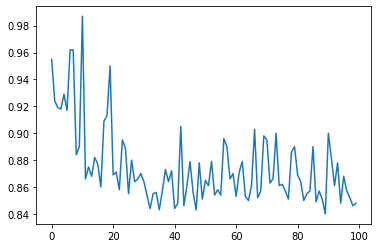

In [ ]:
plt.plot(range(len(loss_list_binary)),loss_list_binary,label='binary with th')

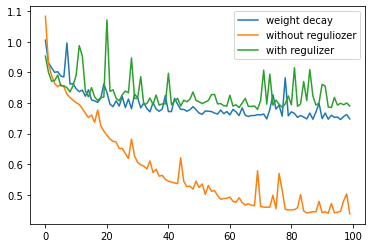

In [ ]:
# first run with 0 th : best loss: 0.84